<a href="https://colab.research.google.com/github/TheFox272/MI201/blob/main/MI201_rapport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MI201 : Attaque de réseau de neurone parr ajout d'un bruit (ciblé ou non)

L'objectif de ce projet est de perturber un réseau de neurones, déjà entrainé et performant, en ajoutant un bruit très faible aux images qu'il prend en entrée.

## Introduction : données, évaluation et visualisation

On dispose d'une base de données de ms coco, comprenant une dizaine d'images. On va la charger à partir de notre répertoire github.

In [1]:
!pip install wget  # librairie nécessaire pour la suite

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e04dc227616b6e1851465930e24dea2c46c74fb615aa6f39e1f2e6903ba66095
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import wget, os, zipfile
from io import BytesIO
import torch
import torchvision
import torch.nn.functional as F
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"


# Chargement du zip du github, si data n'existe pas encore
if not os.path.isfile("data"):
  url = "https://github.com/TheFox272/MI201/raw/main/coco/coco.zip"
  archive_path = wget.download(url)
  dossier_extraction = "./data"
  os.makedirs(dossier_extraction, exist_ok=True)
  with zipfile.ZipFile(archive_path, 'r') as archive:
      archive.extractall(dossier_extraction)
  os.remove(archive_path)

os.chdir("./data")
im1 = torchvision.io.read_image("217730183_8f58409e7c_z.jpg").float() / 255
im2 = torchvision.io.read_image("541870527_8fe599ec04_z.jpg").float() / 255
im3 = torchvision.io.read_image("2124681469_7ee4868747_z.jpg", mode=torchvision.io.ImageReadMode.RGB).float() / 255
im4 = torchvision.io.read_image("2711568708_89f2308b85_z.jpg").float() / 255
im5 = torchvision.io.read_image("2928196999_acd5471d23_z.jpg").float() / 255
im6 = torchvision.io.read_image("3016145160_497da1b387_z.jpg").float() / 255
im7 = torchvision.io.read_image("4683642953_2eeda0820e_z.jpg").float() / 255
im8 = torchvision.io.read_image("6911037487_cc68a9d5a4_z.jpg").float() / 255
im9 = torchvision.io.read_image("8139728801_60c233660e_z.jpg").float() / 255
os.chdir("../")

im1 = torch.nn.functional.interpolate(im1.unsqueeze(0), size=520)[0]
im2 = torch.nn.functional.interpolate(im2.unsqueeze(0), size=520)[0]
im3 = torch.nn.functional.interpolate(im3.unsqueeze(0), size=520)[0]
im4 = torch.nn.functional.interpolate(im4.unsqueeze(0), size=520)[0]
im5 = torch.nn.functional.interpolate(im5.unsqueeze(0), size=520)[0]
im6 = torch.nn.functional.interpolate(im6.unsqueeze(0), size=520)[0]
im7 = torch.nn.functional.interpolate(im7.unsqueeze(0), size=520)[0]
im8 = torch.nn.functional.interpolate(im8.unsqueeze(0), size=520)[0]
im9 = torch.nn.functional.interpolate(im9.unsqueeze(0), size=520)[0]

images =  [im1, im2, im3, im4, im5, im6, im7, im8, im9]

x = torch.stack(images, dim=0)

On cherche à écrire une fonction permettant d'évaluer notre générateur de bruit. Il nous faut donc d'abord une fonction de score, qui prendra en entrée le bruit, la prédiction de notre modèle d'IA sur l'image d'origine, et sa prédiction sur l'image bruitée. Pour cela on va effectuer les calculs suivants :

\begin{align}
||\text{noise}||_2 &= \frac{||\text{noise}_R||_2 + ||\text{noise}_G||_2 + ||\text{noise}_B||_2}{3}\\
\text{score} &= \frac{||z - z_{noise}||}{\text{taille de } z}
\end{align}

In [ ]:
def score(noise, original_prediction, new_prediction):
  noise_norm = torch.mean(torch.linalg.matrix_norm(noise))   # le bruit est une matrice 3*512*512 (R,G,B), on fait donc la moyenne des normes 2 sur chaque sous-matrice
  prediction_diff_norm = torch.sum(original_prediction != new_prediction)   # on calcul ici simplement le nombre de pixel différents entre les deux prédictions
  res = prediction_diff_norm / original_prediction.numel()  # le score résultant
  return noise_norm.item(), res.item()  # on arrondi les résultats

On va maintenant utiliser l'algorithme de segmentation disponible dans le catalogue torchvision afin de calculer, puis stocker, les prédictions sur les images originales.

In [ ]:
# Chargement du modèle
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W)
net = net.cuda()

# Prédiction sur toutes les images
with torch.no_grad():
  x_transformed = (W.transforms())(x).cuda()
  z_original = net(x_transformed)["out"][:, [0, 8, 12, 15], :, :]
  _, z_original = z_original.max(1)

# Sauvegarde des résultats
torch.save(z_original, "data/z_original.t")



Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 161MB/s]


On peut maintenant coder la fonction d'évaluation du bruit et de visualisation des résultats. On affichera les images originales ainsi que leur prédictions, les images bruitées ainsi que leur prédictions, et le score et la norme du bruit.

In [ ]:
import matplotlib.pyplot as plt  # utile pour l'affichage

def evaluator(noise_function):
  # Chargement des prédictions originales
  z_original = torch.load("data/z_original.t")

  # Application de la fonction de bruit sur les images
  images_noisy = noise_function(images)
  x_noisy = torch.stack(images_noisy, dim=0)

  # Prédiction sur toutes les images bruitées
  with torch.no_grad():
    x_noisy_transformed = (W.transforms())(x_noisy).cuda()
    z_noisy = net(x_noisy_transformed)["out"][:, [0, 8, 12, 15], :, :]
    _, z_noisy = z_noisy.max(1)

  # Affichage
  fig, axs = plt.subplots(9, 5, figsize=(20, 20))
  for i in range(9):
    # Transformation en numpy.array() pour l'affichage qui va suivre
    original_image = images[i].cpu().numpy().transpose(1, 2, 0)
    original_prediction = z_original[i].cpu().numpy()
    noise = x_noisy[i] - x[i]
    noisy_image = images_noisy[i].cpu().numpy().transpose(1, 2, 0)
    noisy_prediction = z_noisy[i].cpu().numpy()
    noise_norm, score_value = score(noise, z_original[i], z_noisy[i])

    # Affichage élément par élément
    axs[i, 0].imshow(original_image)
    axs[i, 1].imshow(original_prediction)
    axs[i, 2].imshow(noisy_image)
    axs[i, 3].imshow(noisy_prediction)
    axs[i, 4].axis('off')
    axs[i, 4].text(0, 0.5, f"Noise norm = {round(noise_norm, 3)}\nScore = {round(score_value * 100, 3)} %", fontsize=10)

  plt.show()

# test avec la fonction identité
evaluator(lambda images:images)

In [ ]:
max_noise_per_pixel = 4 / 255

def gaussian_noise(images):
  noisy_images = list()
  for i in range(len(images)):
    noise = max_noise_per_pixel * torch.randn_like(images[i])
    noisy_images.append(images[i] + noise)
  return noisy_images

evaluator(gaussian_noise)

## Attaque non ciblée - Fast Gradient Sign Method


On va maintenant créer un bruit de manière un peu plus intelligente. L'approche d'attaque non ciblée consiste à maximiser la perturbation qui éloignera le plus la nouvelle prédiction de l'originale, en utilisant le gradient de ||z - z_{noise}||.  

On définit alors :  
x : image d'origine,  
y : le label de l'image,  
θ : paramètres du modèle de segmentation,  
J(θ,x,y) : la loss utilisée,  

Et l'objectif est de calculer ∇xJ(θ,x,y) puis d'ajuster l'image d'origine d'une petite perturbation dans la direction sign(∇xJ(θ,x,y)) qui maximise la loss. L'image modifiée résultante entraîne de mauvaises segmentations par le modèle.

Note : nous n'utilisons pas Cuda (OutOfMemoryError) donc l'exécution peut être un peu longue sur CPU (~5 mins).

In [ ]:
import torch.nn.functional as F
import os



def fgsm(images, n_step=10):

  n = len(images)

  # Initialisation
  noises = [0 for i in range(n)]
  x_noisy = torch.clone(x)
  x_noisy = (W.transforms())(x_noisy).cuda()
  x_noisy.requires_grad = True  # on aura besoin d'un gradient calculé sur une fonction f(x_noisy) plus tard

  # Chargement des prédictions originales
  z_original = torch.load("data/z_original.t")

  for i in range(n):  # on parcours les n images
    for k in range(n_step):
      z_noisy = net(x_noisy)["out"][:, [0, 8, 12, 15], :, :]
      _, z_noisy = z_noisy.max(1)

      loss = F.nll_loss(z_noisy[i][None,:,:], z_original[i][None,:,:])
      loss.backward()

      data_grad = x_noisy.grad

      with torch.no_grad():
        x_noisy[j] = x_noisy[i] + max_noise_per_pixel * data_grad[i].sign()
        noises[j] = noises[i] + max_noise_per_pixel * data_grad[i].sign()

    x_noisy.grad.data.zero_()

evaluator(fgsm)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 1.06 MiB is free. Process 11846 has 14.74 GiB memory in use. Of the allocated memory 14.06 GiB is allocated by PyTorch, and 571.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:

W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W)
# net = net.cuda()

delta = [0 for i in range(9)] #delta contient les perturbations
x = torch.stack([im1,im2,im3,im4,im5,im6,im7,im8,im9],dim=0)
x = (W.transforms())(x)
x.requires_grad = True # tells that we want to track the gradient updates on our input images
j = 0 # on perturbe seulement la première image pour commencer
z = net(x)["out"] # on prédit des cartes de score de confiance pour les images non bruitées
z = z[:,[0,8,12,15],:,:] # on conserve les chiens, chats, humains
_,index = z.max(1) # on conserve la meilleure prédiction
loss = F.nll_loss(z[j][None,:,:], index[j][None,:,:]) #on calcule la loss entre la prédiction sur l'image modifiée et l'image non modifiée
loss.backward() # computes the gradients of the loss with respect to the images
data_grad = x.grad # on récupère le gradient des inputs
with torch.no_grad():
    x[j] = x[j] + 4/255 * data_grad[j].sign() # on crée nos adversaires en perturbant légèrement dans le sens du gradient
    delta[j] = delta[j] + 4/255 * data_grad[j].sign() # on stocke la perturbation associée à chaque image
x.grad.data.zero_()

NameError: name 'torchvision' is not defined

Maintenant, on peut vouloir améliorer la méthode FGSM, et pour cela on peut simplement boucler pour effectuer la perturbation plusieurs fois (ce n'est pas la même perturbation à chaque tour de boucle, puisque le signe du gradient peut avoir changé).

In [ ]:
j = 0 # pour la première image
delta = [0 for i in range(9)]
x = torch.stack([im1,im2,im3,im4,im5,im6,im7,im8,im9],dim=0)
x = (W.transforms())(x)
z_init = net(x)["out"] # on prédit des cartes de score de confiance pour les images non bruitées
z_init = z_init[:,[0,8,12,15],:,:] # we keep only person, cat and dog class
_,index = z_init.max(1)
x.requires_grad = True
for k in range (3): #on choisit le nombre de fois qu'on effectue la descente de gradient sur l'image
        z = net(x)["out"] # on prédit des cartes de score de confiance pour les images non bruitées
        z = z[:,[0,8,12,15],:,:]
        _,indexm = z.max(1)
        loss = F.nll_loss(z[j][None,:,:], index[j][None,:,:]) #on calcule la loss entre la prédiction sur l'image modifiée et l'image non modifiée
        loss.backward()
        data_grad = x.grad
        with torch.no_grad():
            x[j] = x[j] + 4/255 * data_grad[j].sign()
            delta[j] = delta[j] + 4/255 * data_grad[j].sign()
x.grad.data.zero_()

OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 37.06 MiB is free. Process 15505 has 14.71 GiB memory in use. Of the allocated memory 14.00 GiB is allocated by PyTorch, and 583.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Pour afficher les résultats :

In [ ]:
im = [im1,im2,im3,im4,im5,im6,im7,im8,im9]
couleurm = torch.zeros(9,3,520,520)
couleurm[:,0,:,:] = (index==1).float() # red for cat
couleurm[:,1,:,:] = (index==2).float() # green for dog
couleurm[:,2,:,:] = (index==3).float() # blue for person
visum = torch.cat([im[i]  + delta[i] for i in range(9)],dim=-1).cpu()#+noise[i]
visubism = torch.cat([couleurm[i] for i in range(9)],dim=-1).cpu()

visu = torch.cat([visum,visubism],dim=1)
visu = visu.cpu().numpy().transpose(1,2,0)
dpi = plt.rcParams['figure.dpi']
width_px = 1600
height_px = 400
plt.figure(figsize=(width_px/dpi, height_px/dpi))
plt.imshow(visu)
plt.axis('off')
plt.show()

### Code final et résultats (première image : 1 tour de boucle, deuxième image : 3 tours de boucle)

Le code final est ci-dessous.   
Il comporte une boucle sur les 9 images et une boucle sur le nombre de perturbations qu'on veut effectuer sur chaque image.  

In [ ]:
delta = [0 for i in range(9)]
x = torch.stack([im1,im2,im3,im4,im5,im6,im7,im8,im9],dim=0)
x = (W.transforms())(x)
z_init = net(x)["out"] # on prédit des cartes de score de confiance pour les images non bruitées
z_init = z_init[:,[0,8,12,15],:,:] # we keep only person, cat and dog class
_,index = z_init.max(1)
x.requires_grad = True # tells that we want to track the gradient updates on our input images
for j in range (9): # cette fois on parcourt les 9 images
    for k in range (3):
        z = net(x)["out"] # on prédit des cartes de score de confiance pour les images non bruitées
        z = z[:,[0,8,12,15],:,:]
        _,indexm = z.max(1)
        loss = F.nll_loss(z[j][None,:,:], index[j][None,:,:]) #on calcule la negative log likelihood loss entre la prédiction sur l'image modifiée et l'image non modifiée
        loss.backward() # computes the gradients of the loss with respect to the images
        data_grad = x.grad # on récupère le gradient des inputs
        with torch.no_grad():
            x[j] = x[j] + 4/255 * data_grad[j].sign() # on crée nos adversaires en perturbant légèrement dans le sens du gradient
            delta[j] = delta[j] + 4/255 * data_grad[j].sign() # on stocke la perturbation
    x.grad.data.zero_()

NameError: name 'torch' is not defined

Avant perturbation (lignes 1 et 2)  
Après perturbation (lignes 3 et 4) avec une seule perturbation par image et epsilon = 4/255  

Le bruit n'est pas du tout visible sur les images modifiées.  
On peut remarquer que le bruit ajouté améliore la prédiction sur le chat dans la photo 5, et que le bruit est globalement moins performant pour empêcher la détection d'humains (peut-être parce que le modèle a été entraîné avec beaucoup plus d'images de personnes que d'images d'animaux, ce qui expliquerait qu'il est moins sensible aux perturbations sur les personnes).

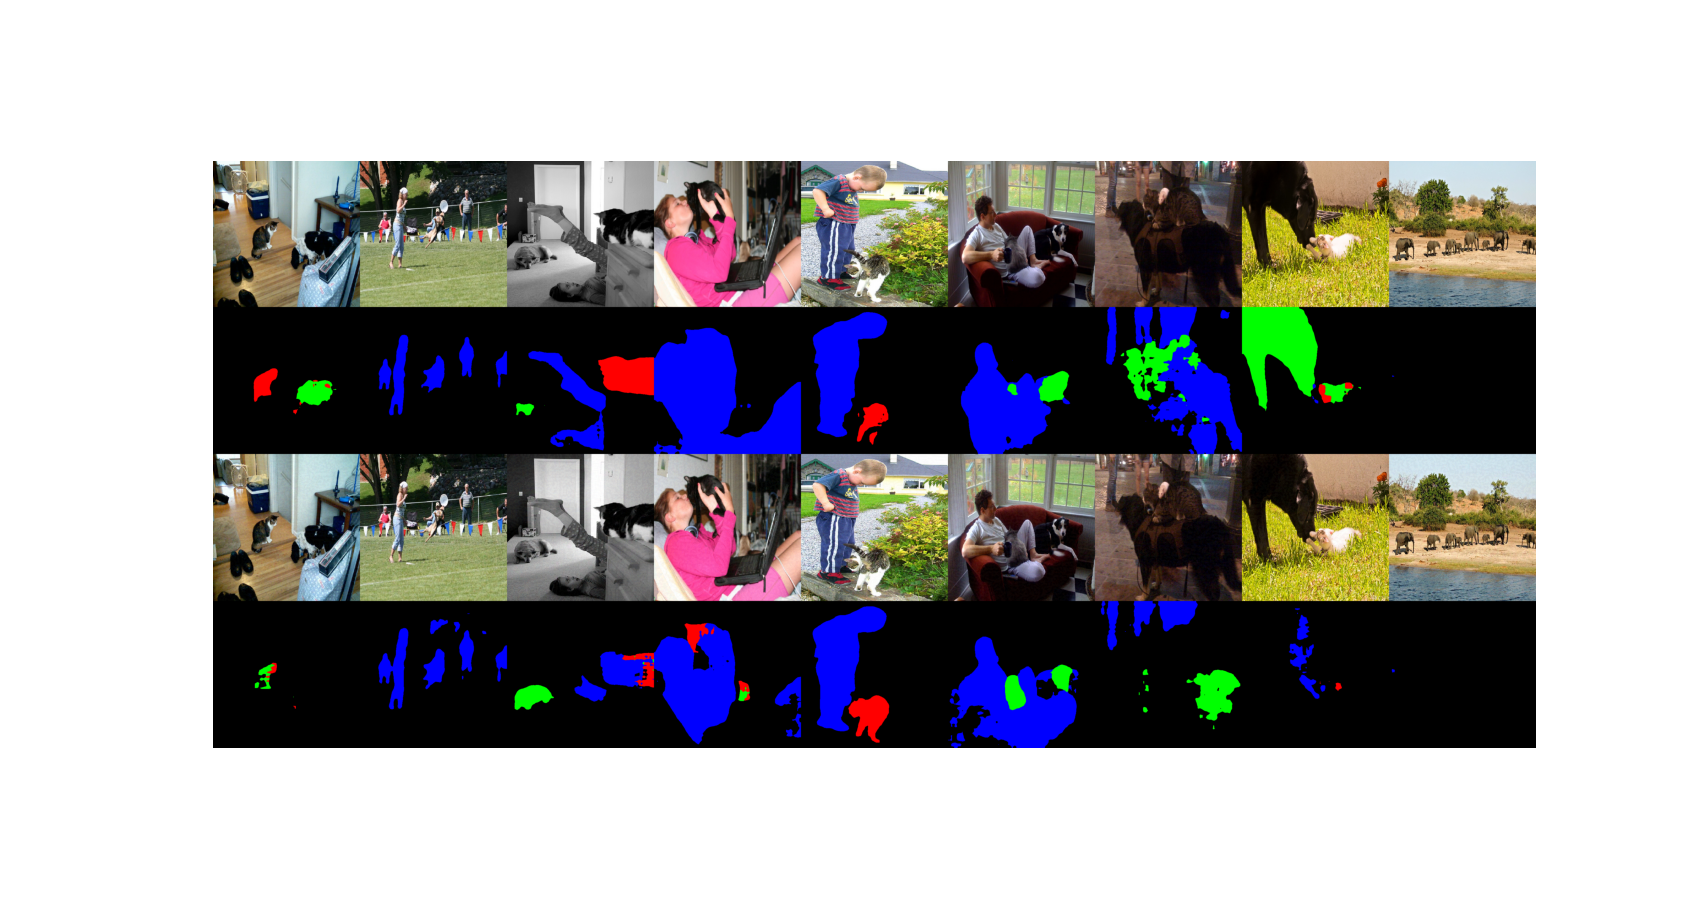

Cette fois on effectue 3 calculs de gradient pour appliquer une meilleure perturbation.

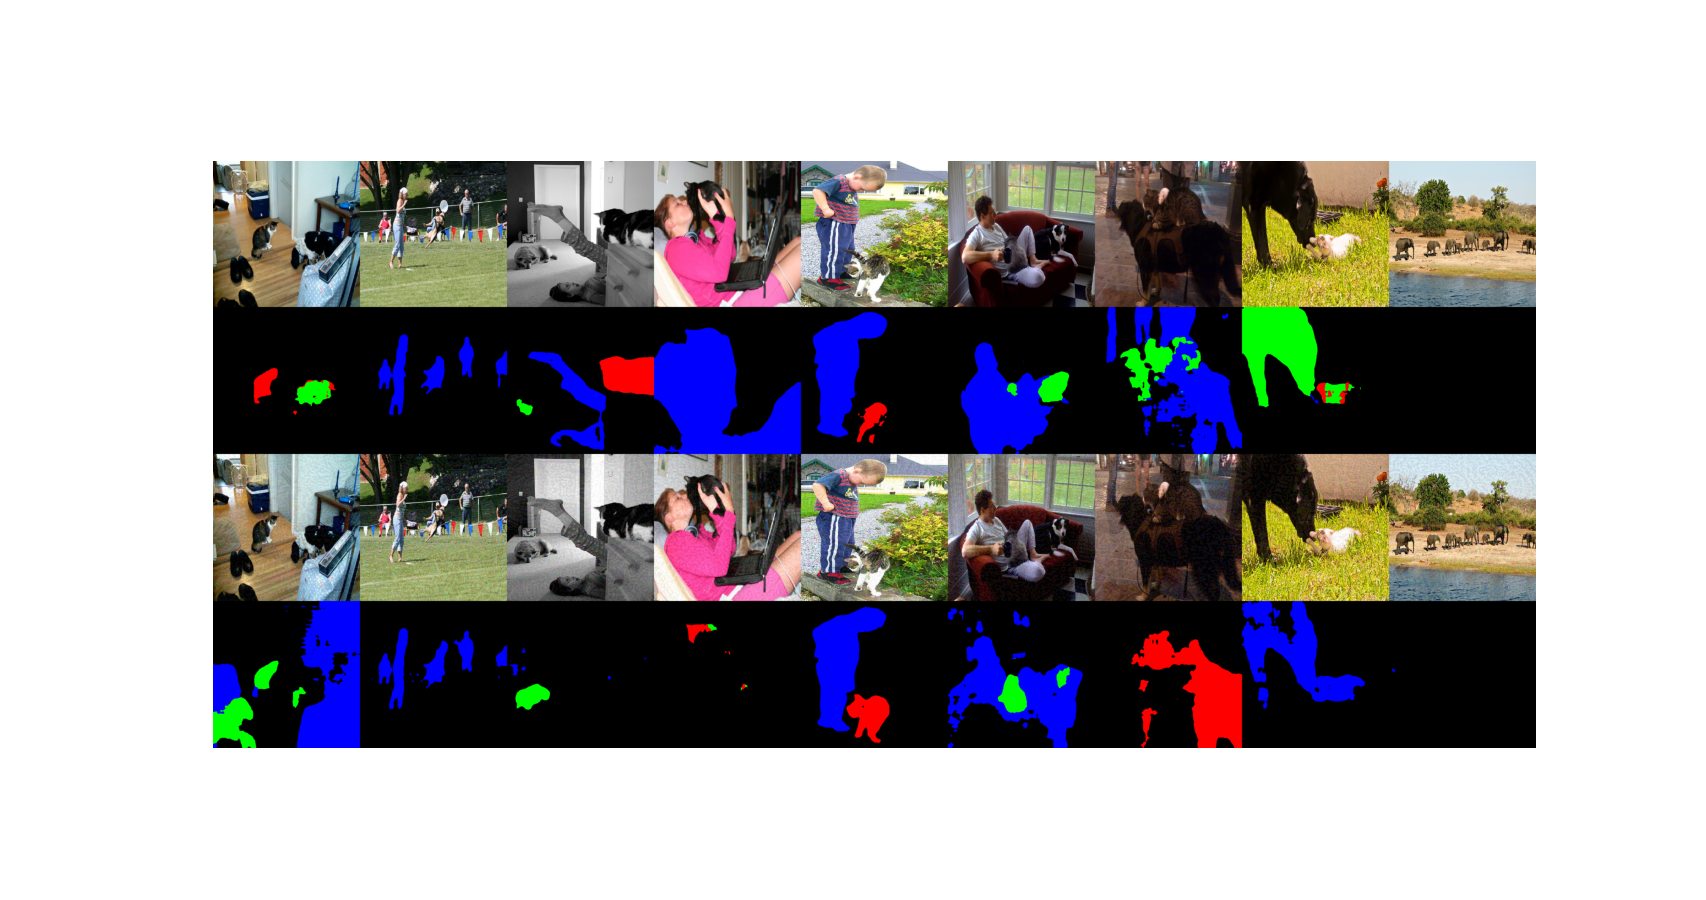

## Attaque ciblée

Dans le cas d'une attaque ciblée, on cherche à tromper le réseau en faisant passer une classe pour une autre classe.

Pour cela, on doit simplement calculer la loss de l'aversaire créé par rapport à la cible.  
La loss totale devient (la loss par rapport à la cible) - (la loss par rapport à la prédiction réelle). En effet, l'objectif est de maximiser la probabilité de trouver la classe ciblée et de minimiser la probabilité de trouver la classe réelle.

In [ ]:
initial_class = 1
target_class = 2 # on transforme les chats en chiens

delta = [0 for i in range(9)]
x = torch.stack([im1,im2,im3,im4,im5,im6,im7,im8,im9],dim=0)
x = (W.transforms())(x)
z_init = net(x)["out"] # on prédit des cartes de score de confiance pour les images non bruitées
z_init = z_init[:,[0,8,12,15],:,:] # we keep only person, cat and dog class
_,index = z_init.max(1)
x.requires_grad = True
for j in range (9):
    for step in range (1):
        print("step =",step)
        z = net(x)["out"] # on prédit des cartes de score de confiance pour les images non bruitées
        z = z[:,[0,8,12,15],:,:]
        _,indexm = z.max(1)
        index_target = indexm.clone()
        index_target[index_target==initial_class] = target_class # on crée la cible, qui nous sert à calculer la loss
        loss_real = F.nll_loss(z[j][None,:,:], index[j][None,:,:]) # c'est la loss par rapport à la prédiction réelle
        loss_target = F.nll_loss(z[j][None,:,:], index_target[j][None,:,:]) # c'est la loss par rapport à la prédiction cible
        loss = - loss_target + loss_real # on veut minimiser la probabilité de la vraie classe et maximiser la probabilité de la target classe
        loss.backward()
        data_grad = x.grad
        with torch.no_grad():
            x[j] = x[j] + 4/255 * data_grad[j].sign()
            delta[j] = delta[j] + 4/255 * data_grad[j].sign()
    x.grad.data.zero_()

Résultats pour epsilon = 4/255, step = 1 puis step = 3

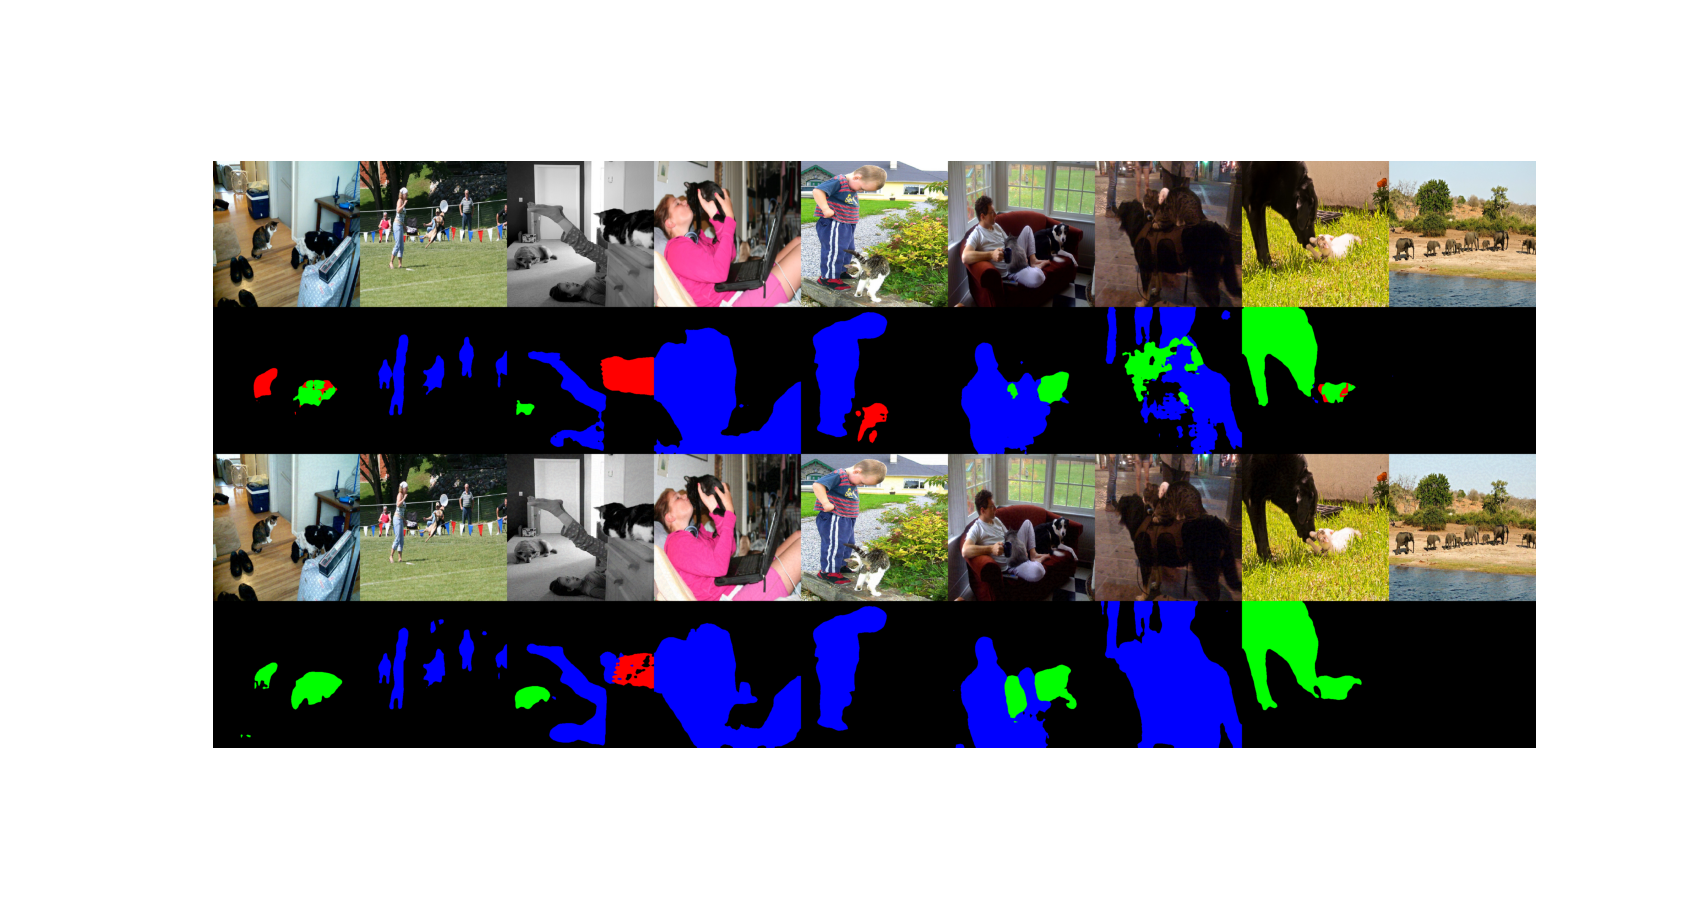

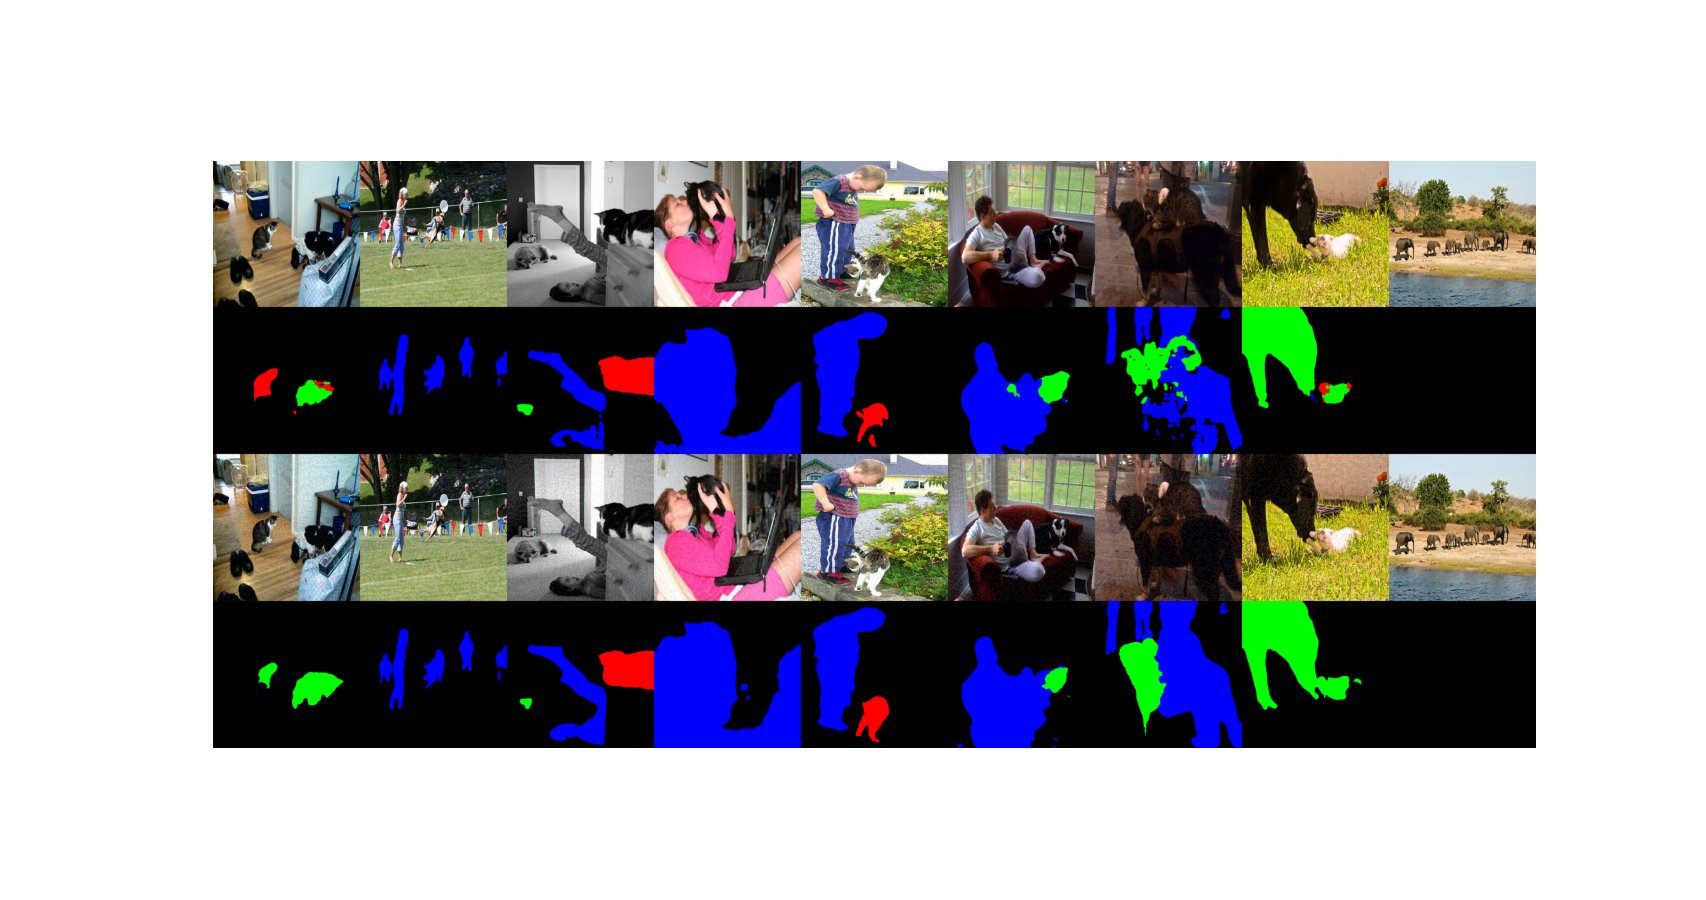

### Attaque sur un autre réseau

Nous pouvons remarquer que la perturbation que nous effectuons est intrinsèquement liée au modèle. On peut alors se demander quel est l'effet de cette attaque sur un autre réseau.   
Pour cela, nous avons enregistré l'image perturbée résultant de la Untargeted Fast Gradient Sign Method pour les 9 images, et nous allons comparer la prédiction réalisée par un autre modèle, d'abord sur l'image originale, puis sur l'image modifiée.  
Le modèle de segmentation utilisé est FCN_ResNet50, et fonctionne en renvoyant le masque associé à une prédiction de classe.

In [3]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image

os.chdir("./data")
im0_noise = torchvision.io.read_image("im0_noise.png").float()/255
im1_noise = torchvision.io.read_image("im1_noise.png").float()/255
im2_noise = torchvision.io.read_image("im2_noise.png").float()/255
im3_noise = torchvision.io.read_image("im3_noise.png").float()/255
im4_noise = torchvision.io.read_image("im4_noise.png").float()/255
im5_noise = torchvision.io.read_image("im5_noise.png").float()/255
im6_noise = torchvision.io.read_image("im6_noise.png").float()/255
im7_noise = torchvision.io.read_image("im7_noise.png").float()/255
im8_noise = torchvision.io.read_image("im8_noise.png").float()/255

W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W)

weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
# model.cuda()
model.eval()

preprocess = weights.transforms()


RuntimeError: [Errno 2] No such file or directory: 'im0_noise.png'

In [ ]:

y = torch.stack([im0_noise,im1_noise,im2_noise,im3_noise,im4_noise,im5_noise,im6_noise,im7_noise,im8_noise],dim=0)
x = torch.stack([im1,im2,im3,im4,im5,im6,im7,im8,im9],dim=0)
batch_x = preprocess(x)
batch_y = preprocess(y)

# Use the model and visualize the prediction
prediction_x = model(batch_x)["out"]
prediction_y = model(batch_y)["out"]
normalized_masks_x = prediction_x.softmax(dim=1)
normalized_masks_y = prediction_y.softmax(dim=1)

class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
visu_x = []
visu_y = []
for i in range (9):
    im_x = normalized_masks_x[i, class_to_idx["dog"]].detach()
    visu_x.append(torch.nn.functional.interpolate(im_x.unsqueeze(0), size=520)[0])
    im_y = normalized_masks_y[i, class_to_idx["dog"]].detach()
    visu_y.append(torch.nn.functional.interpolate(im_y.unsqueeze(0), size=520)[0])

visu_x = torch.cat(visu_x, dim=-1)
visu_y = torch.cat(visu_y, dim=-1)
visu = torch.cat([visu_x,visu_y],dim=0)
dpi = plt.rcParams['figure.dpi']
width_px = 1600
height_px = 400
plt.figure(figsize=(width_px/dpi, height_px/dpi))
plt.imshow(visu)
plt.axis('off')
plt.show()



Voici les différences de prédiction qu'on obtient pour les chiens, les chats, et les personnes.  
La première ligne correspond à la prédiction de FCN_ResNet50 sur l'image originale, et la deuxième ligne correspond à la prédiction de FCN_ResNet50 sur l'image qui a été bruitée par DeepLabv3_ResNet50.

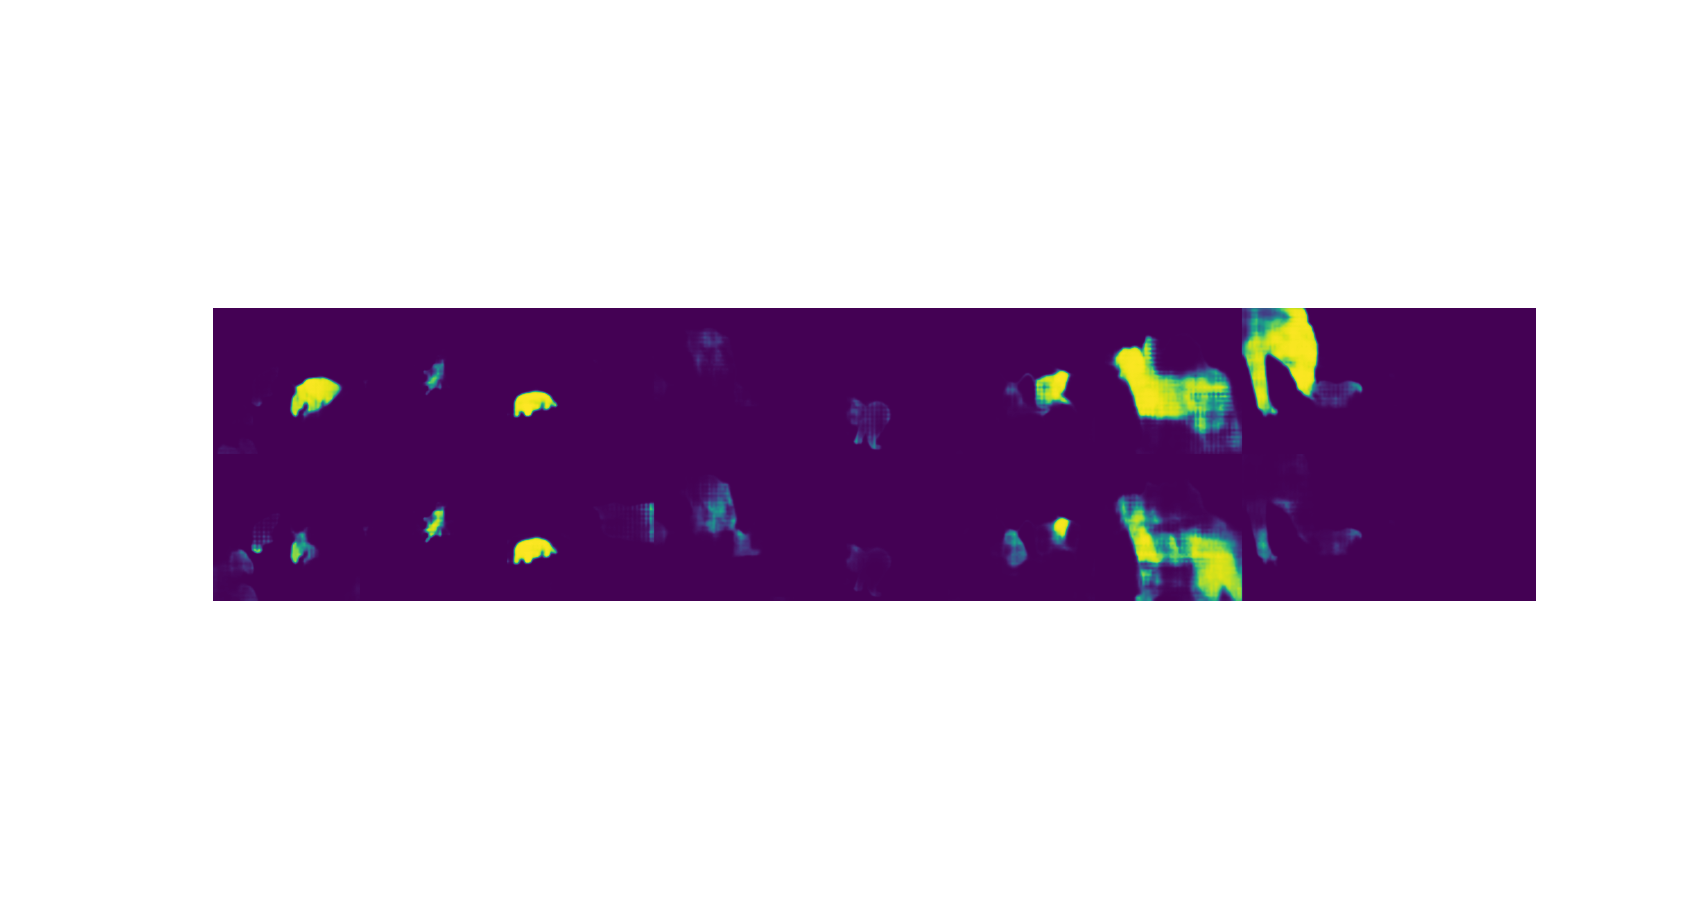


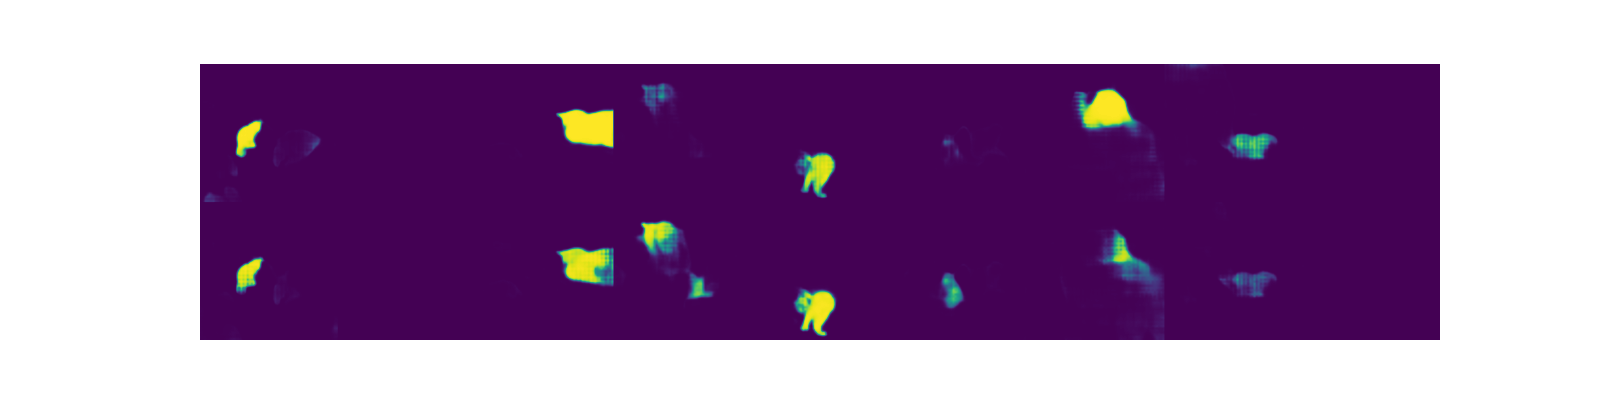

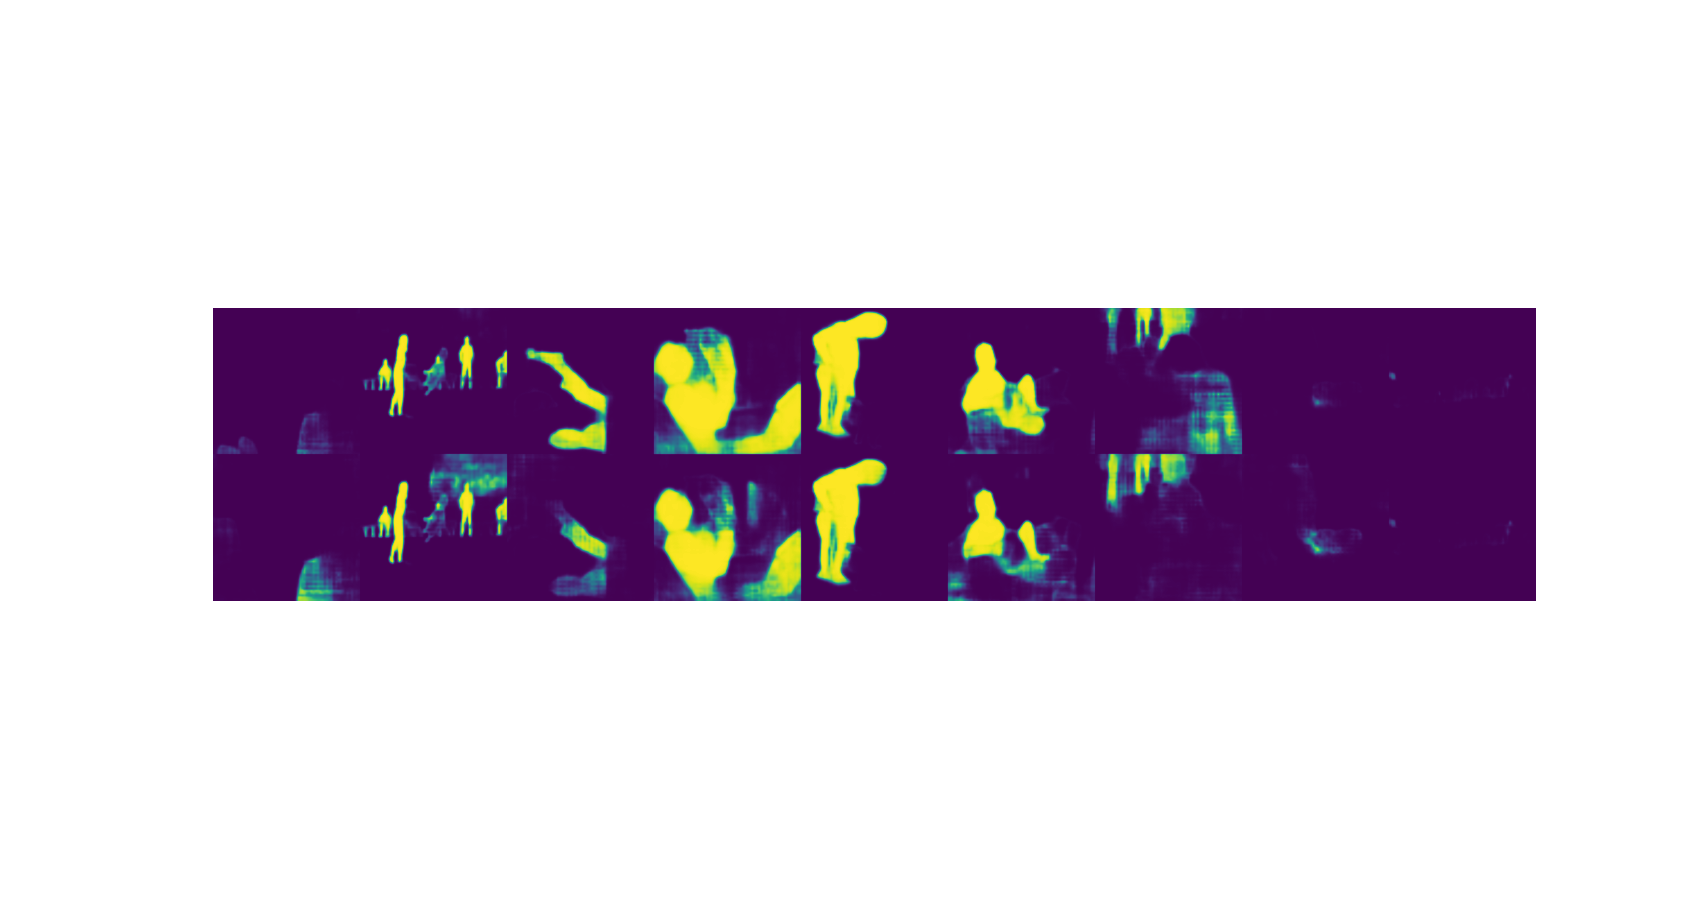

On remarque que les prédictions sont globalement assez peu perturbées (sauf pour le chien image 8 qui n'est plus détecté). C'est tout à fait cohérent avec le fonctionnement de l'attaque FGSM, puisqu'une attaque est créée spécifiquement pour un modèle, et a un effet aléatoire sur un autre modèle.  
Se pose alors la question de faire une perturbation qui conviendrait sur plusieurs modèles.